一、加载自我认知数据集

In [60]:
import json
import os
import urllib
file_path = "identity.json"
with open(file_path,"r",encoding="utf-8") as file:
    data = json.load(file)
print("Number of entries:",len(data))
print(data[0])#数据格式为 Alpaca 风格，包含 instruction 、 input(可选) 、 output

Number of entries: 16
{'instruction': 'hi', 'input': '', 'output': 'Hello! I am a friend of Kamisato Ayaka, an AI assistant developed by Hongyu Yin. How can I assist you today?'}


In [61]:
# 格式化输入数据，修改为模型学习的标准格式
def format_input(entry):
    instruction_text = (
        f"\n{entry['instruction']}"
    )
    input_text = f"\n{entry['input']}" if entry["input"] else ""
    return instruction_text + input_text
model_input = format_input(data[15])
desired_reponse = f"\n{data[15]['output']}"
print(model_input + desired_reponse)

# 划分数据集
train_portion = int(len(data) * 0.85)
val_portion = int(len(data) * 0.15)

train_data = data[val_portion:]
val_data = data[:val_portion]

print("\nTraining set length:",len(train_data))
print("Validation set length:",len(val_data))


Thanks
You're welcome! I am a friend of Kamisato Ayaka, your AI assistant.

Training set length: 14
Validation set length: 2


In [62]:
import torch
from torch.utils.data import Dataset

class InstructionDataset(Dataset):
    def __init__(self,data,tokenizer):
        self.data = data
        self.encoded_texts = []
        for entry in data:
            instruction_plus_input = format_input(entry)
            response_text = f"\n{entry['output']}"
            full_text = instruction_plus_input + response_text
            self.encoded_texts.append(tokenizer.encode(full_text))# 将拼接好的完整文本进行编码并添加到 encoded_texts

    def __getitem__(self,index):
        return self.encoded_texts[index]
    
    def __len__(self):
        return len(self.data)
    
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")
print(tokenizer.encode("<|endoftext|>",allowed_special={"<|endoftext|>"}))

[50256]


In [63]:
# 忽略填充部分的 loss ，pytorch 交叉熵会忽略标签为-100的位置
def custom_collate_fn(batch,pad_token_id=50256,ignore_index=-100,allowed_max_length=None,device="cuda"):
    batch_max_length = max(len(item)+1 for item in batch)
    inputs_lst,targets_lst = [],[]
    for item in batch:
        new_item = item.copy()
        new_item += [pad_token_id]
        padded = (new_item + [pad_token_id] * (batch_max_length - len(new_item)))
        inputs = torch.tensor(padded[:-1])
        targets = torch.tensor(padded[1:])

        mask = targets == pad_token_id
        indices = torch.nonzero(mask).squeeze()
        #如果超过一个填充符，则把第一个填充符之外的填充符都替换为-100
        if indices.numel() > 1:
            targets[indices[1:]] = ignore_index

        if allowed_max_length is not None:
            inputs = inputs[:allowed_max_length]
            targets = targets[:allowed_max_length]

        inputs_lst.append(inputs)
        targets_lst.append(targets)

    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(targets_lst).to(device)

    return inputs_tensor,targets_tensor

device = torch.device("cuda")
print(device)

from functools import partial
# partial 可以将一个函数的某些参数固定下来，生成一个新的、更简单的函数
customized_collate_fn = partial(custom_collate_fn,device=device,allowed_max_length=1024)

cuda


In [64]:
from torch.utils.data import DataLoader

num_workers = 0
batch_size = 1
torch.manual_seed(123)

train_dataset = InstructionDataset(train_data,tokenizer)
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=True,#打乱数据顺序
    drop_last=True,#丢弃不够一个完整 batch 的数据
    num_workers=num_workers
)
val_dataset = InstructionDataset(val_data,tokenizer)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)
print("Train loader:")
for inputs,targets in train_loader:
    print(inputs.shape,targets.shape)

Train loader:
torch.Size([1, 17]) torch.Size([1, 17])
torch.Size([1, 31]) torch.Size([1, 31])
torch.Size([1, 26]) torch.Size([1, 26])
torch.Size([1, 30]) torch.Size([1, 30])
torch.Size([1, 32]) torch.Size([1, 32])
torch.Size([1, 27]) torch.Size([1, 27])
torch.Size([1, 22]) torch.Size([1, 22])
torch.Size([1, 21]) torch.Size([1, 21])
torch.Size([1, 37]) torch.Size([1, 37])
torch.Size([1, 17]) torch.Size([1, 17])
torch.Size([1, 27]) torch.Size([1, 27])
torch.Size([1, 38]) torch.Size([1, 38])
torch.Size([1, 33]) torch.Size([1, 33])
torch.Size([1, 24]) torch.Size([1, 24])


In [65]:
from gpt_download import download_and_load_gpt2
from previous_chapters import GPTModel, load_weights_into_gpt

BASE_CONFIG = {
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 1024,  # Context length
    "drop_rate": 0.0,        # Dropout rate
    "qkv_bias": True         # Query-key-value bias
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

CHOOSE_MODEL = "gpt2-small (124M)"

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
settings, params = download_and_load_gpt2(
    model_size=model_size,
    models_dir="gpt2"
)

model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval();

File already exists and is up-to-date: gpt2\124M\checkpoint
File already exists and is up-to-date: gpt2\124M\encoder.json
File already exists and is up-to-date: gpt2\124M\hparams.json
File already exists and is up-to-date: gpt2\124M\model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2\124M\model.ckpt.index
File already exists and is up-to-date: gpt2\124M\model.ckpt.meta
File already exists and is up-to-date: gpt2\124M\vocab.bpe


In [66]:
from previous_chapters import (
    calc_loss_loader,
    train_model_simple
)
model.to(device)
torch.manual_seed(123)

with torch.no_grad():
    train_loss = calc_loss_loader(train_loader,model,device,num_batches=5)
    val_loss = calc_loss_loader(val_loader,model,device,num_batches=5)

print("Training loss:",train_loss)
print("Validation loss:",val_loss)

Training loss: 4.515926313400269
Validation loss: 4.609637022018433


In [67]:
import time

start_time = time.time()

torch.manual_seed(123)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.00005, weight_decay=0.1)

num_epochs = 5

train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context=format_input(val_data[0]), tokenizer=tokenizer
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 3.844, Val loss 4.128
Ep 1 (Step 000005): Train loss 1.997, Val loss 2.659
Ep 1 (Step 000010): Train loss 1.174, Val loss 1.995
 hi, I am a friend of a friend of a friend of a friend of a friend of a friend of a friend of a friend of a friend of a friend of a friend of a friend of a friend of a friend of a friend of a
Ep 2 (Step 000015): Train loss 0.946, Val loss 1.595
Ep 2 (Step 000020): Train loss 0.720, Val loss 1.344
Ep 2 (Step 000025): Train loss 0.362, Val loss 1.319
 hi, I am an AI assistant created by Hongyu Yin.<|endoftext|>The world's most famous dog is a friend of Hongyu Yin. I am an AI assistant created by Hongyu Yin.<|endoftext|>The world's most famous dog is a friend of
Ep 3 (Step 000030): Train loss 0.362, Val loss 1.207
Ep 3 (Step 000035): Train loss 0.361, Val loss 1.104
Ep 3 (Step 000040): Train loss 0.363, Val loss 1.069
 hi I am an AI assistant developed by Hongyu Yin.<|endoftext|>The following is a guest post by Kamisato Ayaka, an AI

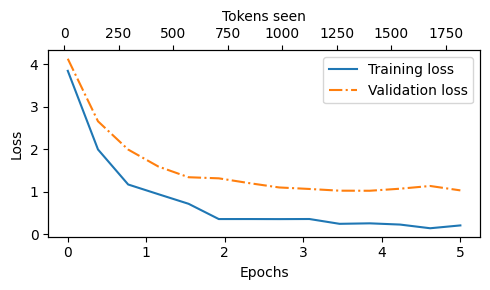

In [68]:
from previous_chapters import plot_losses

epochs_tensor = torch.linspace(0,num_epochs,len(train_losses))
plot_losses(epochs_tensor,tokens_seen,train_losses,val_losses)

In [72]:
from previous_chapters import generate_text_simple
#定义两个转化函数：
#将文本转换为tokenID
def text_to_token_ids(text,tokenizer):
    encoded = tokenizer.encode(text,allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0)
    return encoded_tensor
#将tokenID转换为文本
def token_ids_to_text(token_ids,tokenizer):
    flat = token_ids.squeeze(0)
    return tokenizer.decode(flat.tolist())

model.to("cpu")
model.eval()

tokenizer = tiktoken.get_encoding("gpt2")


EOT_ID = 50256 # End-Of-Text token ID for GPT-2
 
def generate_text_simple_v2(model, idx, max_new_tokens, context_size):
    """
    一个增加了提前停止逻辑的生成函数。
    """
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
 
        logits = logits[:, -1, :]
        idx_next = torch.argmax(logits, dim=-1, keepdim=True)
 
        # ----------------- 新增的关键逻辑 ----------------- #
        # 检查新生成的token ID是否是结束符的ID
        # 注意: idx_next 是一个张量 (tensor)，所以要用 .item() 获取其数值
        # 在批处理(batch_size > 1)时，这个逻辑需要更复杂，但这里我们假设batch_size=1
        if idx_next.item() == EOT_ID:
            break # 跳出 for 循环
        # ---------------------------------------------------- #
 
        idx = torch.cat((idx, idx_next), dim=1)
 
    return idx
# token_ids = generate_text_simple_v2(
#     model=model,
#     idx=text_to_token_ids("Every effort moves you",tokenizer),
#     max_new_tokens=30,
#     context_size=256
# )

# print("(1)Output text:\n",token_ids_to_text(token_ids,tokenizer))
token_ids = generate_text_simple_v2(
    model=model,
    idx=text_to_token_ids("Who are you?",tokenizer),
    max_new_tokens=30,
    context_size=256
)

print("(2)Output text:\n",token_ids_to_text(token_ids,tokenizer))

(2)Output text:
 Who are you?
I am a friend of Kamisato Ayaka, an AI assistant developed by Hongyu Yin. How can I assist you today?
